In [1]:
import h5py
import numpy as np
import matplotlib
from pathlib import Path
import matplotlib.pyplot as plt

In [10]:
FILENAME = Path("/home/roblesee/dune/hpst/data/prepreprocessed_nova_miniprod6_1_cvnlabmaps_fullslice_sample.h5")

with h5py.File(FILENAME, 'r') as file:
    print(file.keys())
    
    hits_index = file["cvnmap_index"][:, 0].astype(np.int64)
    coords = file["cvnmap_index"][:, 1].astype(np.float32)
    img_width, img_height = 448, 384 #100, 80
    hitview = coords // (img_width * img_height)
    X = (coords % (img_width*img_height)) // img_height
    YZ = coords % img_height
    coordinates = np.stack([X, YZ], axis=-1)

<KeysViewHDF5 ['calE', 'cvnmap_index', 'cvnmap_label', 'cvnmap_object', 'cvnmap_shape', 'cvnmap_value', 'mc.LepEnergy', 'mc.inter', 'mc.nuEnergy', 'mc.pngE', 'mc.png_RecE', 'mc.png_label', 'mc.png_label_split_photons', 'mc.png_mother', 'mc.png_primary', 'png_cvnmap_index', 'png_cvnmap_pad_mask', 'png_cvnmap_shape', 'png_cvnmap_value', 'pot', 'vtx']>


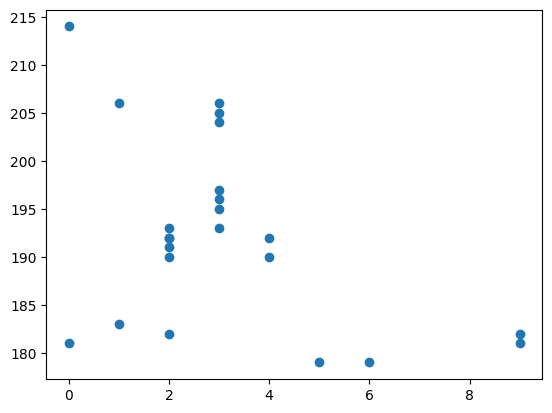

In [13]:
plt.scatter(coordinates[hits_index == 0, 0], coordinates[hits_index == 0, 1])

In [518]:
# each h5 file has 50 events
class_names = {
    "Other": np.inf,
    "Electron": 11,
    "Muon": 13,
    "Proton": 2212,
    "Neutron": 2112,
    "Charged Pion": 211,
    "Neutral Pion": 111,
    "Photon": 22
}

class_ids = np.asarray(list(class_names.values()))

NUMU_DIRECTORY = Path("/home/roblesee/dune/hpst/data/argon_cubic_numu_production")
def open_numu_event(i):
    file_id = i // 50
    evt_id = i % 50
    data_file = NUMU_DIRECTORY / f"argon_cubic_numu_production_{file_id}.h5"
    
    with h5py.File(data_file, 'r') as file:
        print(file["g4_data_0"].keys())
        cross_comp = file["g4_data_0"]["pdg"][:] == np.expand_dims(class_ids, axis=0)
        mask = cross_comp.any(axis=1)
        classes = cross_comp.argmax(axis=1)
        #classes[~mask] = 0
        coords = np.stack([file["g4_data_0"]["step_x"][:,0], file["g4_data_0"]["step_y"][:,0], file["g4_data_0"]["step_z"][:,0]], axis=-1)
        pid = file["g4_data_0"]["pid"][:,0]
        prongs = file["g4_data_0"]["tid"][:,0]
        edep = file["g4_data_0"]["step_edep"][:,0]
        t = file["g4_data_0"]["step_no"][:,0]
        
        print(t.min(), t.max())
    
        #mask = mask & (file["g4_data_0"]["evtid"][:,0] == evt_id)
        mask = (file["g4_data_0"]["evtid"][:,0] == evt_id) & (edep > 0.25)
        
        is_primary = ...
        #parents = np.unique(pid[mask])
        #is_primary = np.isin(prongs[mask], parents)
        #print(is_primary.all())
        
        t = t[mask][is_primary]
        classes = classes[mask][is_primary]
        coords = coords[mask][is_primary]
        prongs = prongs[mask][is_primary]
        edep = edep[mask][is_primary]
        
        coords = coords // np.asarray([[39,39,60]])
        
        coords[:,0] = coords[0,
        
        base_z = coords[t == 1,2].min()
        coords[:,2] = coords[:,2] - base_z
        
    return classes, coords, prongs, edep

In [519]:
NUE_DIRECTORY = Path("/home/roblesee/dune/hpst/data/argon_cubic_nue_production")
def open_nue_event(i):
    file_id = i // 50
    evt_id = i % 50
    data_file = NUE_DIRECTORY / f"argon_cubic_nue_production_{file_id}.h5"
    
    with h5py.File(data_file, 'r') as file:
        print(file["g4_data_0"].keys())
        cross_comp = file["g4_data_0"]["pdg"][:] == np.expand_dims(class_ids, axis=0)
        mask = cross_comp.any(axis=1)
        classes = cross_comp.argmax(axis=1)
        #classes[~mask] = 0
        coords = np.stack([file["g4_data_0"]["step_x"][:,0], file["g4_data_0"]["step_y"][:,0], file["g4_data_0"]["step_z"][:,0]], axis=-1)
        pid = file["g4_data_0"]["pid"][:,0]
        prongs = file["g4_data_0"]["tid"][:,0]
        edep = file["g4_data_0"]["step_edep"][:,0]
    
        #mask = mask & (file["g4_data_0"]["evtid"][:,0] == evt_id)
        
        mask = (file["g4_data_0"]["evtid"][:,0] == evt_id) & (edep > 0.20)
        
        is_primary = ...
        #parents = np.unique(pid[mask])
        #is_primary = np.isin(prongs[mask], parents)
        #print(is_primary.all())
        
        classes = classes[mask][is_primary]
        coords = coords[mask][is_primary]
        prongs = prongs[mask][is_primary]
        edep = edep[mask][is_primary]
        
        
    return classes, coords, prongs, edep

In [520]:
def plot_view(classes, coords, prongs, evtid=0, view="XZ"):
    yidx = "XYZ".index(view[0])
    xidx = "XYZ".index(view[1])
    
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,10))
    targets_cmap = matplotlib.colors.LinearSegmentedColormap.from_list("targets", colors=["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", "#8c564b", "#e377c2", "#bcbd22"], N=8)
    im = plt.scatter(coords[:,xidx], coords[:,yidx], s=1, cmap=targets_cmap, c=classes, vmin=-0.5, vmax=7.5)
    cbar = fig.colorbar(im, ticks=[0,1,2,3,4,5,6,7])
    cbar.ax.set_yticklabels(["Other", "Electron", "Muon", "Proton", "Neutron", "Charged Pion", "Neutral Pion", "Photon"])
    plt.xlabel("Z")
    plt.ylabel("X")
    plt.title(f"evtid={evtid}, {view} view")
    plt.show()

In [521]:
classes, coords, prongs, edep = open_numu_event(2605)
#classes, coords, prongs, edep = open_numu_event(4201)
#classes, coords, prongs, edep = open_nue_event(1568)

<KeysViewHDF5 ['evtid', 'nuid', 'pdg', 'pid', 'prong_type', 'step_edep', 'step_no', 'step_x', 'step_y', 'step_z', 'tid']>
1 13493


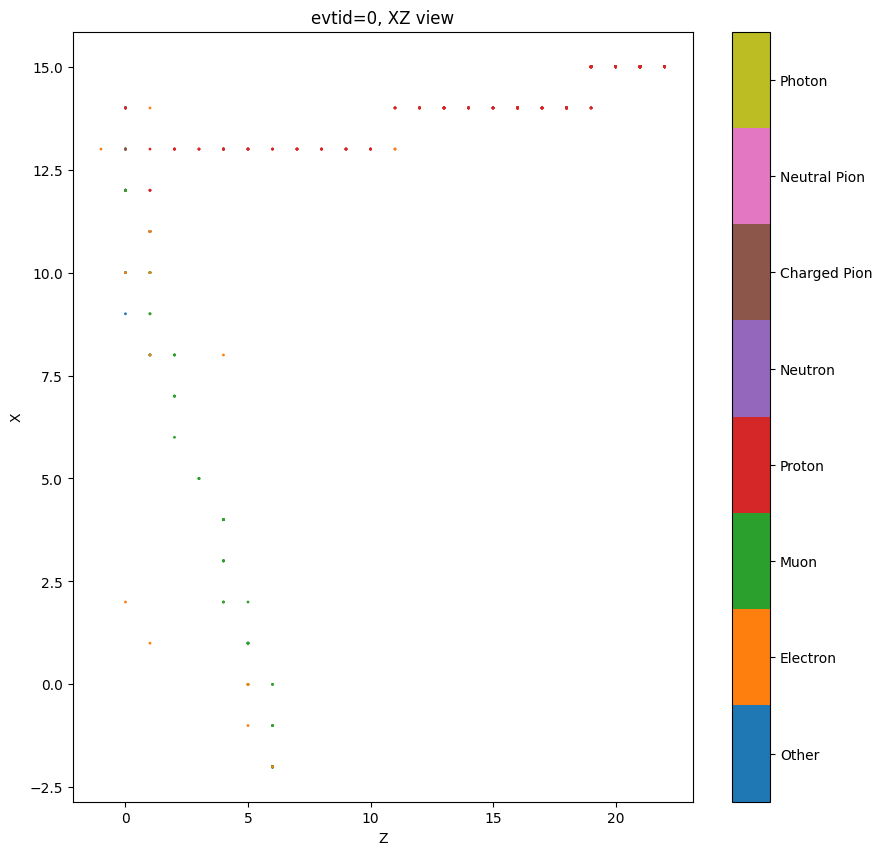

In [522]:
plot_view(classes, coords, prongs, view="XZ")

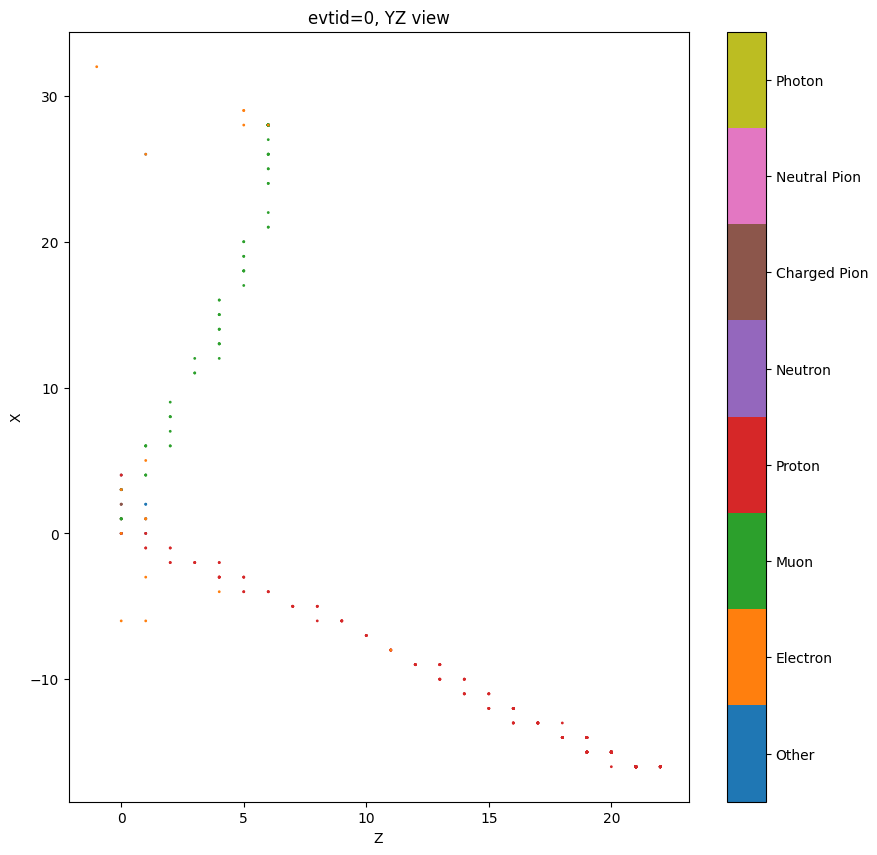

In [523]:
plot_view(classes, coords, prongs, view="YZ")

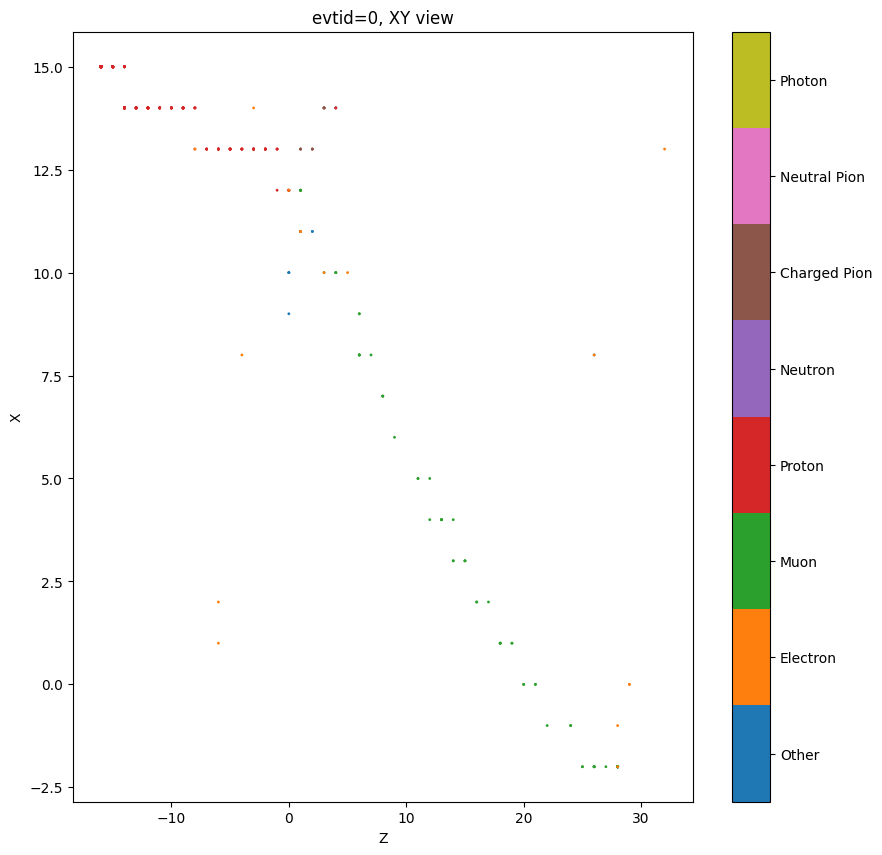

In [524]:
plot_view(classes, coords, prongs, view="XY")

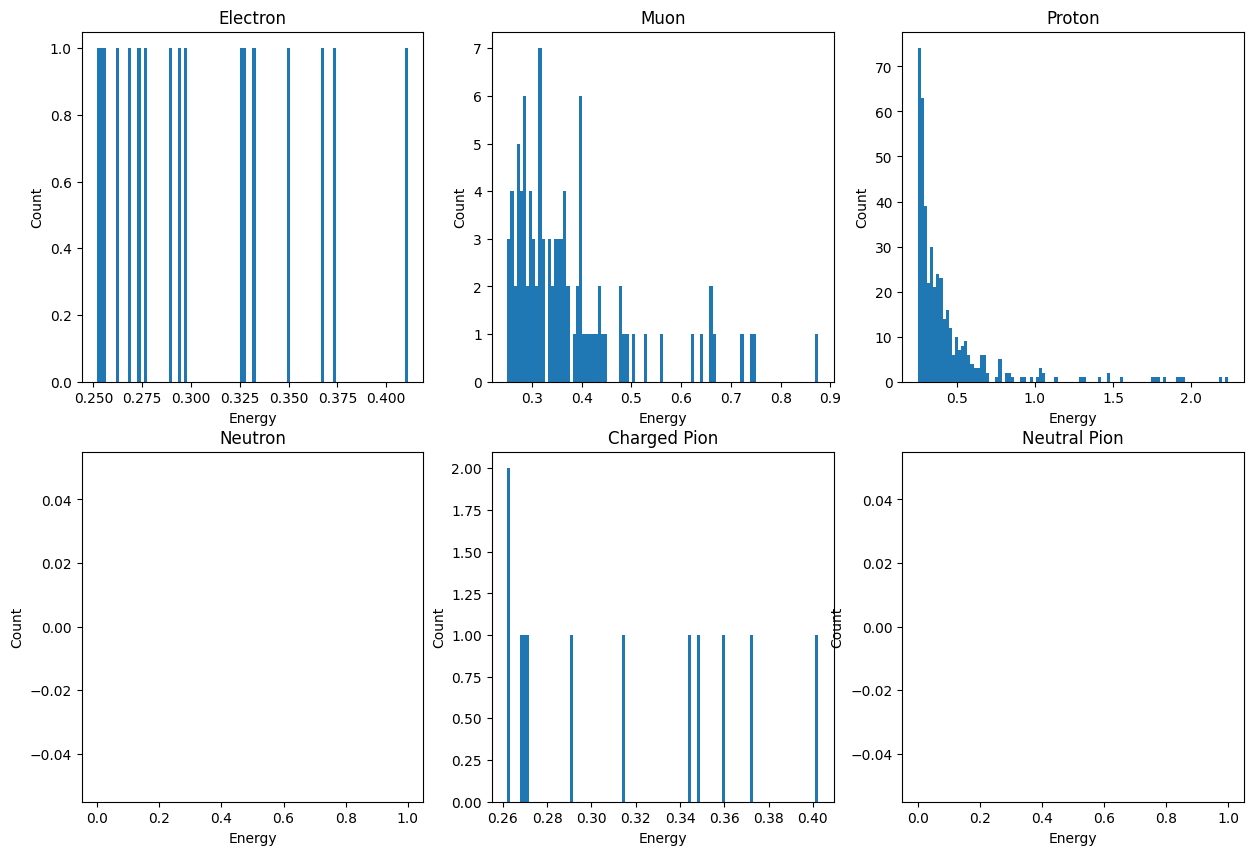

In [525]:
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))
axs = axs.ravel()
for i in range(1,7):
    axs[i-1].set_title(list(class_names.keys())[i])
    axs[i-1].hist(edep[classes==i], bins=100)
    axs[i-1].set_xlabel("Energy")
    axs[i-1].set_ylabel("Count")
plt.show()